Explore the raw data provided:
    * forest disturbances
    * Land Use

In [1]:
import geopandas as gpd
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gdal

# 1. Forest Disturbances
## Helpers

In [42]:
def rasterize(shp, dst, feat, epsg):
    cmd = f'gdal_rasterize -a_srs {epsg} -a {feat} -tr 10 10 -ot Int32 -a_nodata 0 {shp} {dst}'
    os.system(cmd)
    return


## Understand data

In [18]:
data_dir = '/mnt/uksa-storage/disturbances/'
projection = 'EPSG:32615'

In [4]:
os.chdir(data_dir)

In [5]:
data = gpd.read_file('forestchange_footprint_current_change.shp')

In [6]:
data.shape

(34184, 6)

In [28]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry,year
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((609921.956 1714553.182, 609935.465 1...",2018
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((609826.861 1714664.203, 609813.352 1...",2018
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((609891.673 1715235.822, 609905.182 1...",2018
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((610040.200 1715250.467, 610026.692 1...",2018
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((610123.589 1714763.163, 610110.080 1...",2018


In [8]:
(data['deliveryda']==data['enddate']).sum()

34184

In [9]:
len(data['deliveryda'].unique())

75

In [10]:
data['deliveryda'].unique()

array(['20180202000000', '20180214000000', '20180226000000',
       '20180310000000', '20180322000000', '20180403000000',
       '20180415000000', '20180427000000', '20180509000000',
       '20180521000000', '20180602000000', '20180614000000',
       '20180626000000', '20180708000000', '20180720000000',
       '20180801000000', '20180813000000', '20180825000000',
       '20180906000000', '20180918000000', '20180930000000',
       '20181012000000', '20181024000000', '20181105000000',
       '20181117000000', '20181129000000', '20181211000000',
       '20181223000000', '20190104000000', '20190116000000',
       '20190128000000', '20190209000000', '20190221000000',
       '20190305000000', '20190317000000', '20190329000000',
       '20190410000000', '20190422000000', '20190504000000',
       '20190516000000', '20190528000000', '20190621000000',
       '20190703000000', '20190715000000', '20190727000000',
       '20190820000000', '20190925000000', '20191007000000',
       '20191019000000',

In [11]:
len(data['pkid'].unique())

34184

In [12]:
len(data['aoi'].unique())

1

In [17]:
# check projection 
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
# change projection to mercator
data= data.to_crs(projection)
# save shp
data.to_file('forest_change_mercator.shp')

In [24]:
data.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

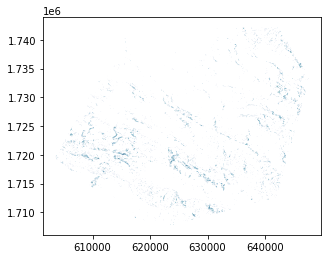

In [21]:
data.plot()

In [25]:
# only year
data['year'] = data['enddate'].str[:4]

In [26]:
a,b = np.unique(data['year'], return_counts = True)
print(a)
print(b)

['2018' '2019' '2020']
[16851 14374  2959]


In [27]:
data.groupby('year').aggregate(sum)

,pkid,area_ha
year,,
2018,826794315,638.501951
2019,929674385,458.482080
2020,217024896,82.441104


We note there has been much less deforestation in 2020 relative to the previous years

In [36]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry,year
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((609921.956 1714553.182, 609935.465 1...",2018
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((609826.861 1714664.203, 609813.352 1...",2018
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((609891.673 1715235.822, 609905.182 1...",2018
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((610040.200 1715250.467, 610026.692 1...",2018
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((610123.589 1714763.163, 610110.080 1...",2018


## Rasterize data

In [43]:
rasterize('forest_change_mercator.shp', 'forest_change_by_year.tif', 'year', 'EPSG:32615')

In [44]:
rst = rasterio.open('forest_change_by_year.tif')
rst.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 4401, 'height': 3440, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603558.1124792217,
       0.0, -10.0, 1742194.128229793), 'tiled': False, 'interleave': 'band'}

In [45]:
rst_dt = rst.read(1)
a,b = np.unique(rst_dt, return_counts=True)

In [48]:
print(a)
print(b)

[   0 2018 2019 2020]
[15021061    64077    46052     8250]


The nb of 10x10m pixels matches the hectares deforested in the raw data - rasterization was succesful

# 2. Land Use

In [33]:
data_lui = '/mnt/uksa-storage/land_cover'

In [34]:
os.chdir(data_lui)

In [35]:
# LABELS
# let's see what the class labels correspond to
with open('GSI_LandNow_LCC_Delivery_2_ColourMap.clr') as f:
    lines = f.readlines()
    
labels = {}
for l in lines:
    labels.update({int(l.split(' ')[0]):l.split(' ')[-2]})
labels.update({11:'coffee'})
labels.update({-9999:'outside AOI'})



## Helpers

In [36]:
def read_lui(filename, year, labels):
    """Read LUI and return class counts in dataframe"""
    rst = rasterio.open(filename)
    data = rst.read(1)
    a, b = np.unique(data, return_counts=True)
    df = pd.DataFrame(index =a)
    df['lui'] = df.index.map(labels)
    df['counts']=b
    df['year']=year
    return rst, data, df


## Raw folder

In [37]:
# raw data from 2020
rst_raw_20, dt_raw_20, df_raw_20  = read_lui('2020/Raw/GSI_LandNow_LCC_2020_Iteration_2.tif', 2020, labels)

In [38]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

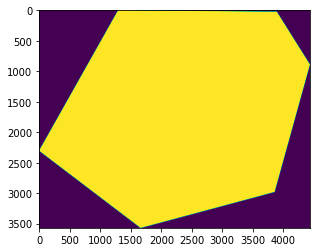

In [39]:
plt.imshow(dt_raw_20)

In [40]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [41]:
# raw data from 2017
rst_raw_17, dt_raw_17, df_raw_17  = read_lui('2017/Raw/GSI_LandNow_LCC_2017_Iteration_2.tif', 2017, labels)

In [42]:
rst_raw_17.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

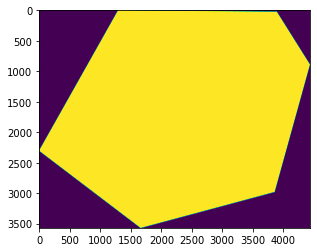

In [43]:
plt.imshow(dt_raw_17)

In [44]:
df_raw_17

,lui,counts,year
-9999,outside AOI,4427012,2017
1,Shrubs,372140,2017
2,Vegetation,226316,2017
3,Cropland,1466284,2017
4,Urban,235404,2017
5,vegetation,280857,2017
7,body,11752,2017
10,Forest,5649376,2017
11,coffee,3202202,2017


In [45]:
# confirm the AOI is the same in 2017 and 2020
df_raw_17['counts'].sum()==df_raw_20['counts'].sum()

True

In [46]:
# combine both years
raw_lui_combined = df_raw_17.append(df_raw_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

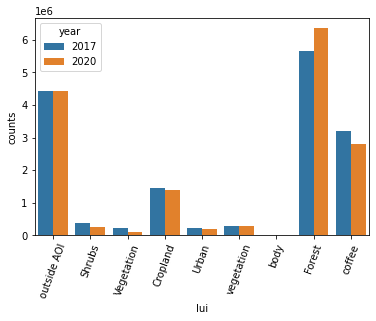

In [47]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = raw_lui_combined)
plt.xticks(rotation=70)

We note that total forest cover has increased between 2017 and 2017, as a result of a reduction in land cultivation: cropland and coffee classes are in dedcline

## Smoothed folder

In [48]:
# smoothed data from 2020
rst_smooth_20, dt_smooth_20, df_smooth_20  = read_lui('2020/Smoothed/GSI_LandNow_LCC_2020_Iteration_2_Smoothed.tif', 2020, labels)


In [49]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [50]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [51]:
# smoothed data from 2017
rst_smooth_17, dt_smooth_17, df_smooth_17  = read_lui('2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed.tif', 2017, labels)


In [52]:
# combine both years
smooth_lui_combined = df_smooth_17.append(df_smooth_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

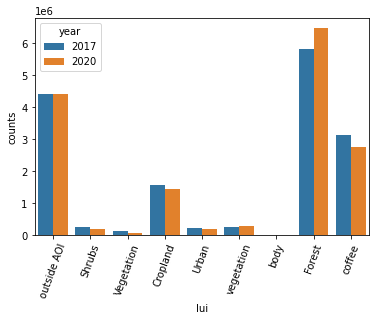

In [53]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = smooth_lui_combined)
plt.xticks(rotation=70)

We just use the smoothed LUI. Note that we'll train the model using the 2017 LUI, BUT make the projections for 2021 using the 2020 forest cover!